# Import

In [35]:
## Imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from scipy.stats import chi2_contingency, pearsonr, spearmanr, mannwhitneyu, f_oneway
from os.path import exists
from importlib import reload

import model
import wrangle
import warnings
warnings.filterwarnings("ignore")


# Wrangle

In [5]:
reload(wrangle)

<module 'wrangle' from '/Users/sinao/codeup-data-science/unemployment_project/wrangle.py'>

In [6]:
df = wrangle.prep_aug()

## Split dataframe

In [7]:
def split_scale(df):   
    #train_test_split
    train_validate, test = train_test_split(df, test_size=.2, random_state=514, stratify=df['employed'])
    train, validate = train_test_split(train_validate, test_size=.3, random_state=514, stratify=train_validate['employed'])
    
    #create scaler object
    scaler = MinMaxScaler()

    # create copies to hold scaled data
    train_scaled = train.copy(deep=True)
    validate_scaled = validate.copy(deep=True)
    test_scaled =  test.copy(deep=True)

    #create list of numeric columns for scaling
    num_cols = train.select_dtypes(include='number')

    #fit to data
    scaler.fit(num_cols)

    # apply
    train_scaled[num_cols.columns] = scaler.transform(train[num_cols.columns])
    validate_scaled[num_cols.columns] =  scaler.transform(validate[num_cols.columns])
    test_scaled =  scaler.transform(test[num_cols.columns])

    return train, validate, test, train_scaled, validate_scaled, test_scaled

In [8]:
train, validate, test, train_scaled, validate_scaled, test_scaled = split_scale(df)

# Explore 

## Univariate

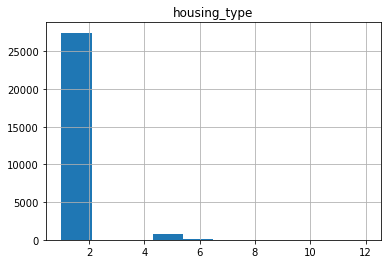

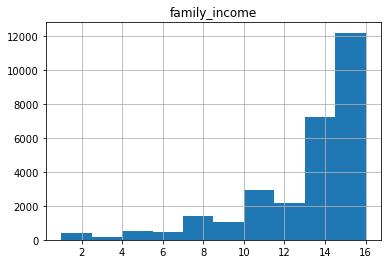

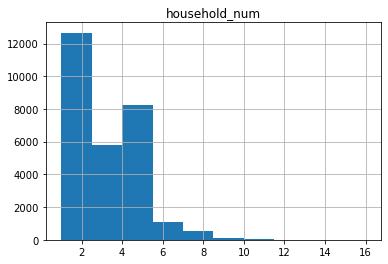

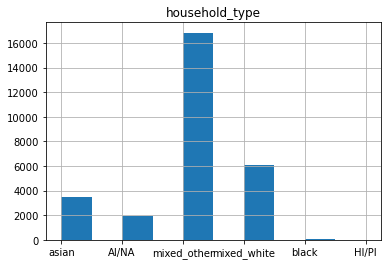

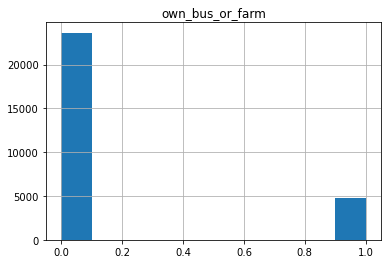

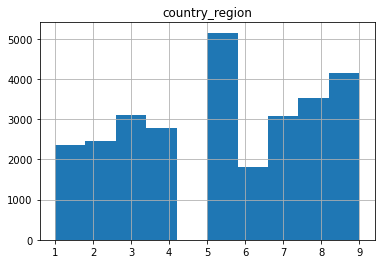

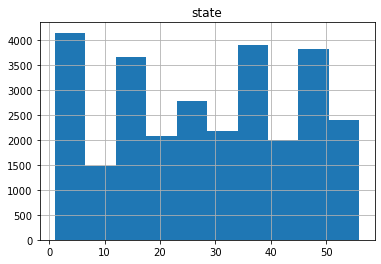

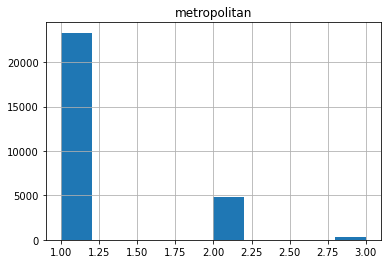

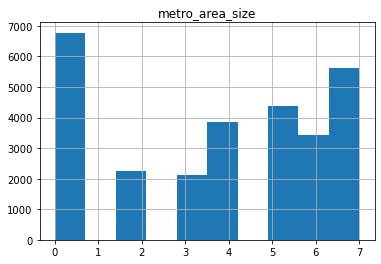

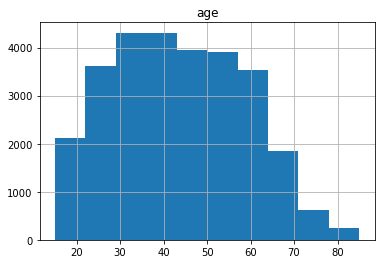

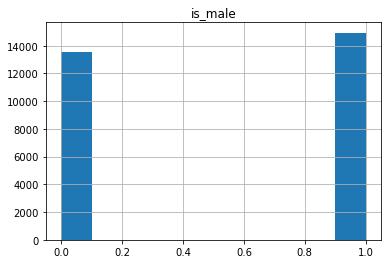

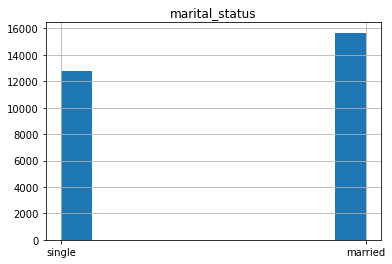

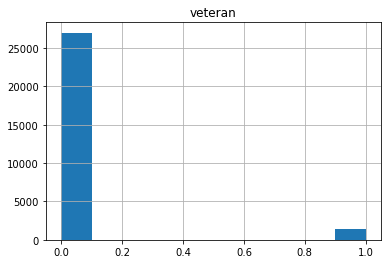

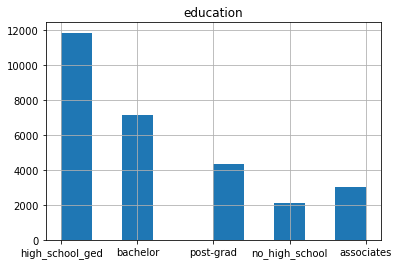

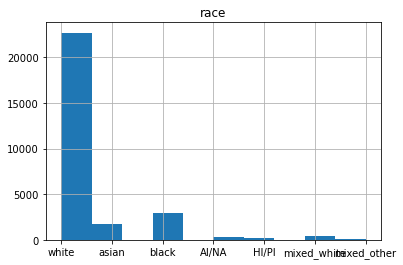

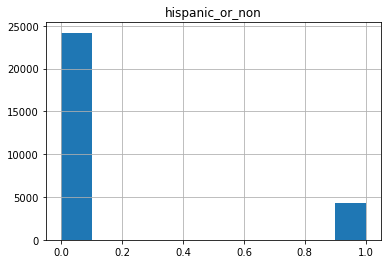

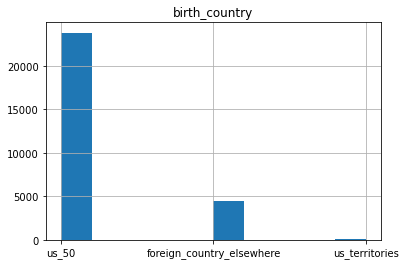

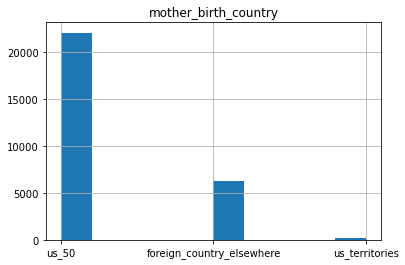

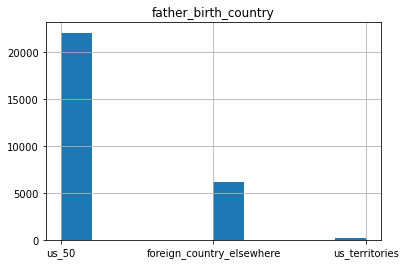

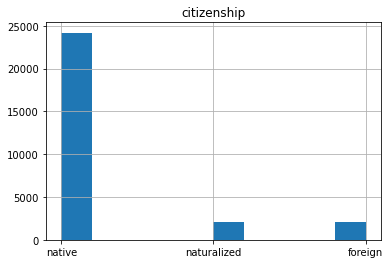

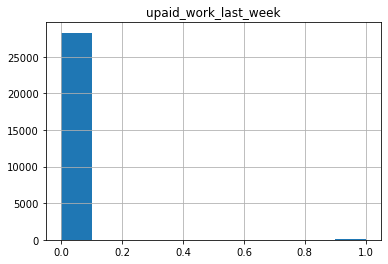

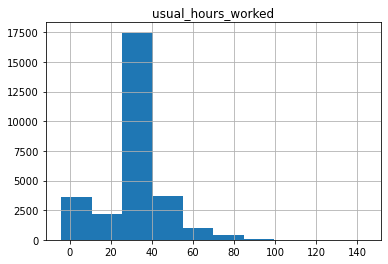

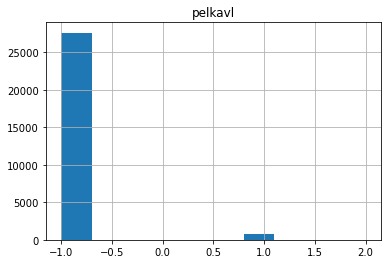

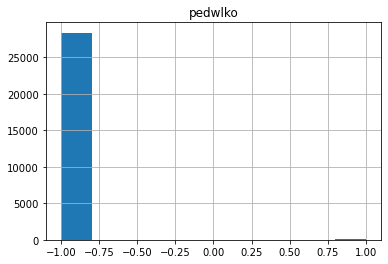

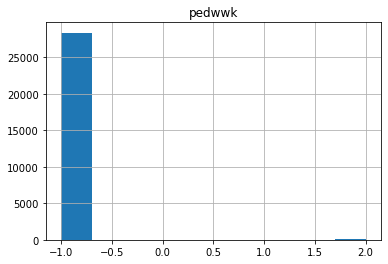

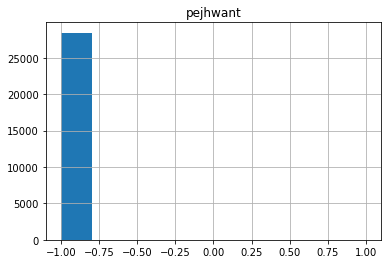

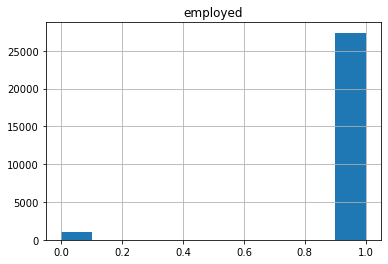

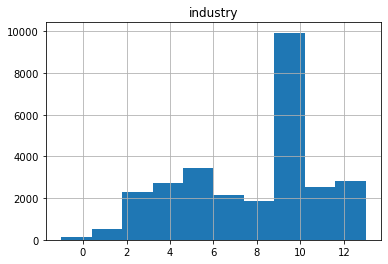

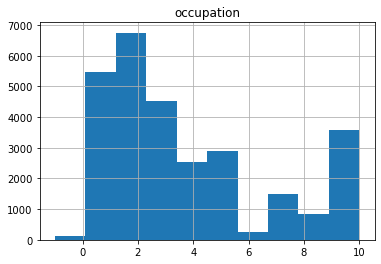

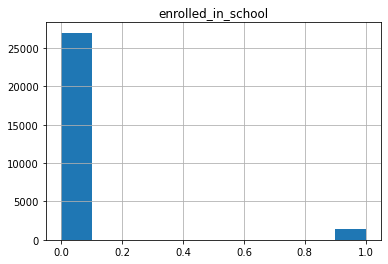

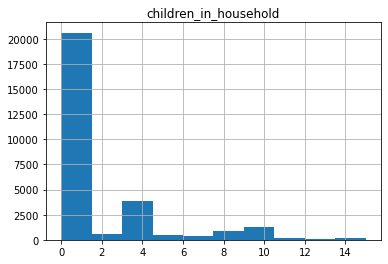

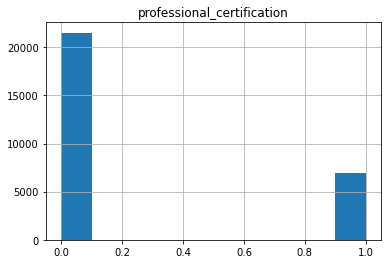

In [9]:
for col in train.columns:
    train[col].hist()
    plt.title(col)
    plt.show()

### Takeaways
* Skewed:
    - `family_income`, `household_num`, 'household_type`
* many responses from region 5 (south_atlantic)
* almost all respondents worked in last 12 months (train split)
* eliminate - `could_have_started_job`

## Bivariate - Pairplots 
* Examine variables in relationship to each other

In [10]:
# create column filter lists for plotting use

#fixing types on categorical columns
categorical_cols = ['housing_type','family_income','household_type',
                'country_region','state','metropolitan','metro_area_size',
                'marital_status','education','race','birth_country',
                'mother_birth_country','father_birth_country','citizenship',
                'industry','occupation']

binary_cols = ['own_bus_or_farm', 'is_male', 'veteran','hispanic_or_non', 
                'employed', 'enrolled_in_school','professional_certification']  

continuous_cols = ['age', 'household_num', 'children_in_household'] 

In [11]:
def plot_continuous_pairs (df, col_list):
    """ 
    Purpose
        Plot pairwise relationships of zillow dataframe
        Ignores Categorical columns
    
    Parameters
        df: a dataframe containing zillow real estate data

    Returns
        None
    """

    #initialize a seaborn pairgrid
    g = sns.PairGrid(df[col_list])
    
    #fills out the pairgrid with a regplot
    g.map(sns.regplot, line_kws={'color':'r'})
    return 

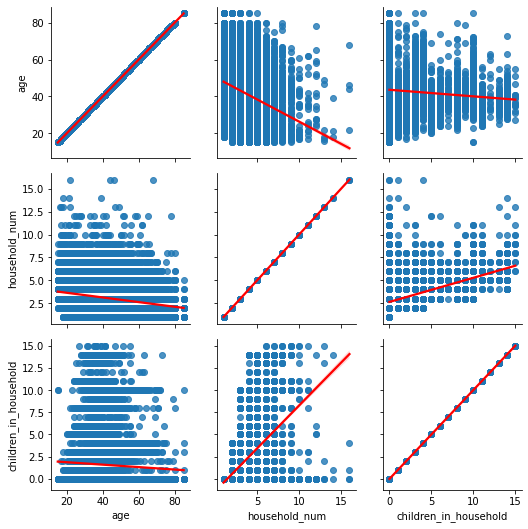

In [12]:
plot_continuous_pairs(train, continuous_cols)

### Takeaways
- Increases in age track with decreases in home size

## Bivariate - Categorical Plotting

In [13]:
unemployed = train[train.employed == 0]

<Figure size 1440x432 with 0 Axes>

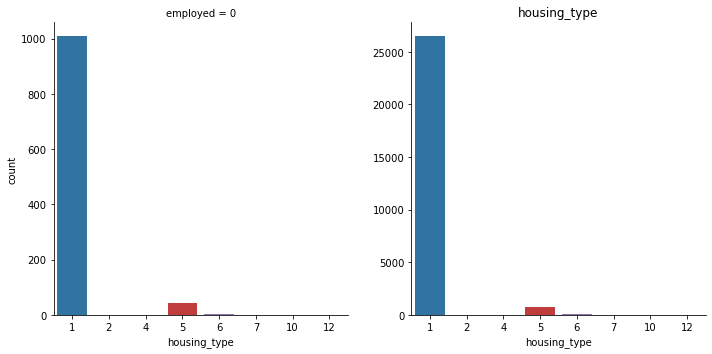

<Figure size 1440x432 with 0 Axes>

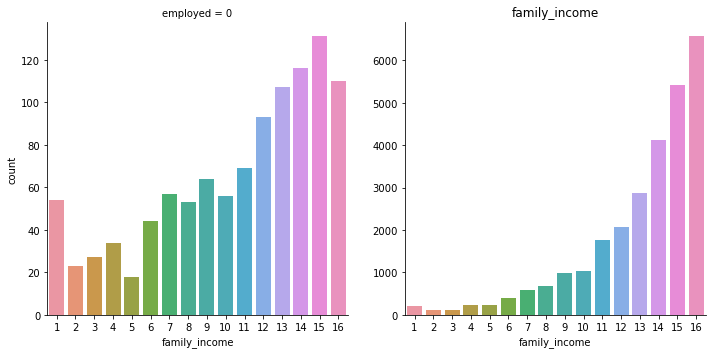

<Figure size 1440x432 with 0 Axes>

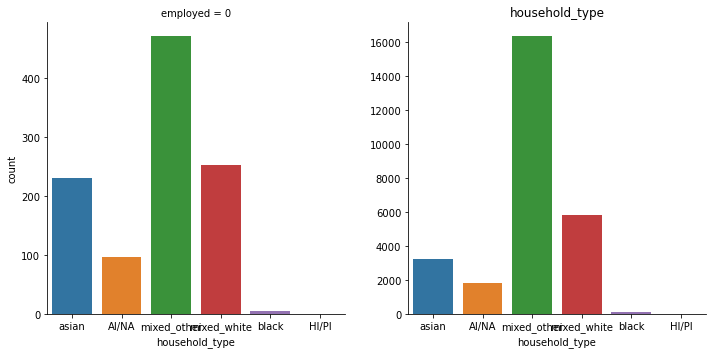

<Figure size 1440x432 with 0 Axes>

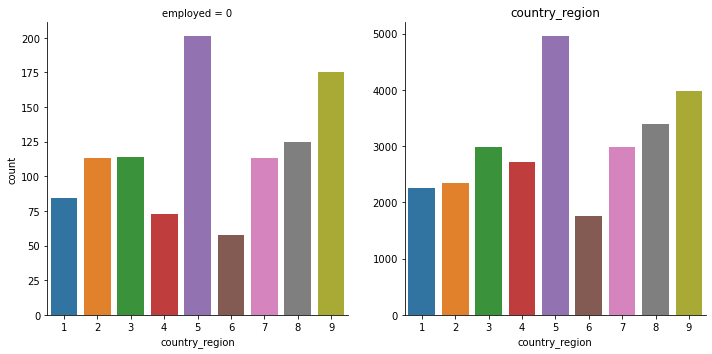

<Figure size 1440x432 with 0 Axes>

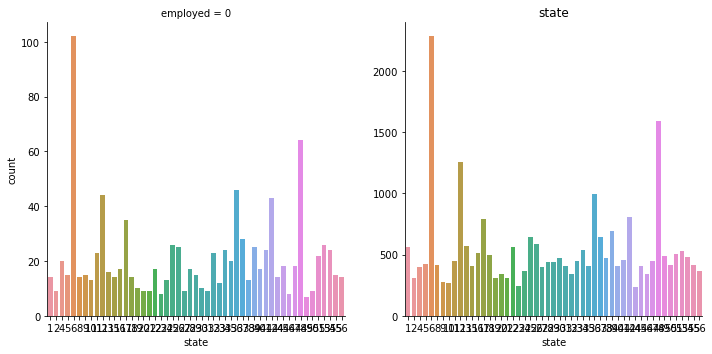

<Figure size 1440x432 with 0 Axes>

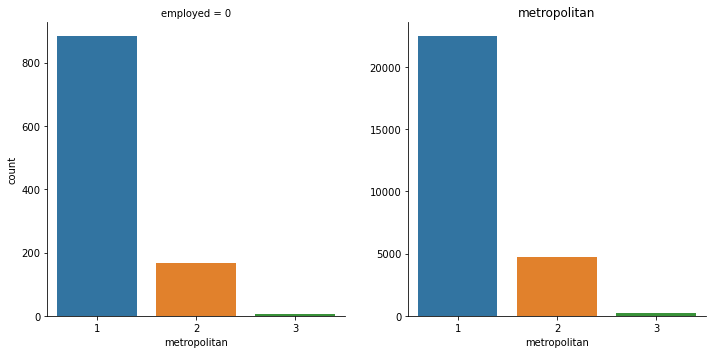

<Figure size 1440x432 with 0 Axes>

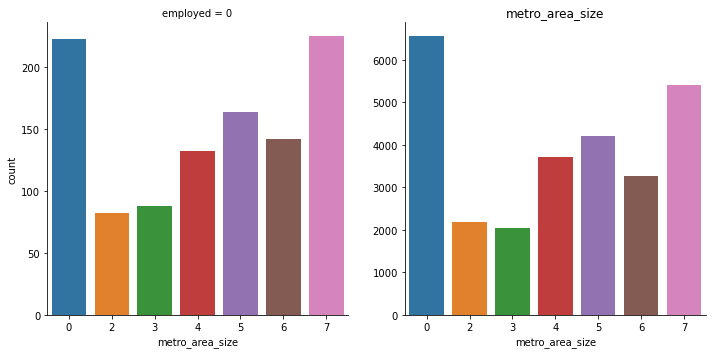

<Figure size 1440x432 with 0 Axes>

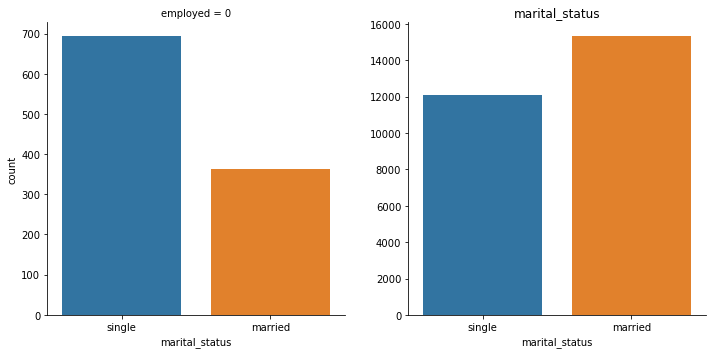

<Figure size 1440x432 with 0 Axes>

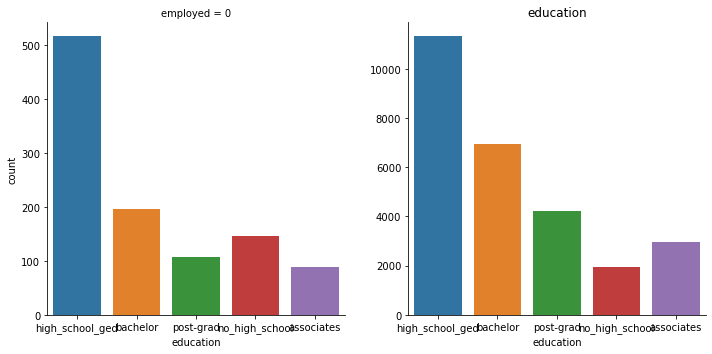

<Figure size 1440x432 with 0 Axes>

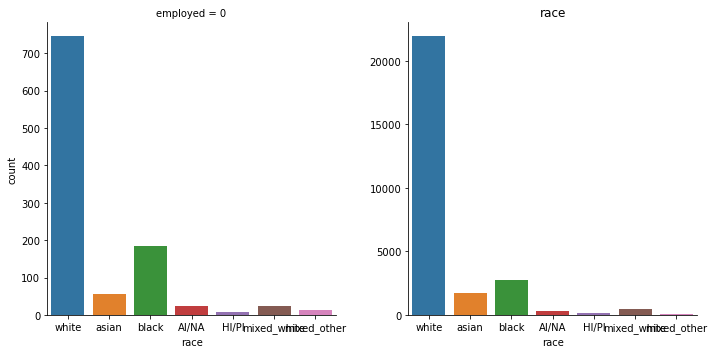

<Figure size 1440x432 with 0 Axes>

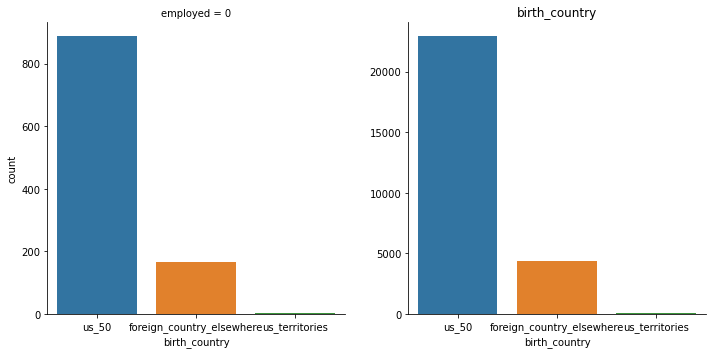

<Figure size 1440x432 with 0 Axes>

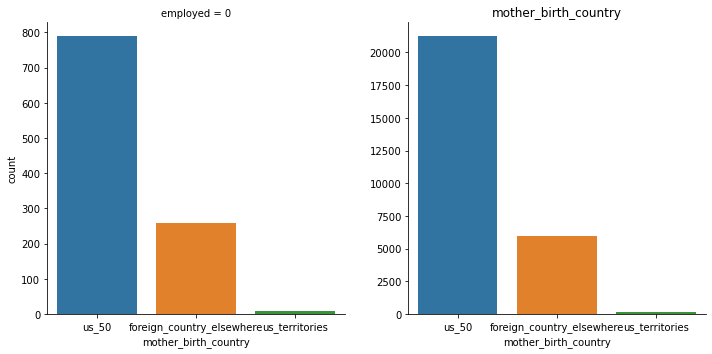

<Figure size 1440x432 with 0 Axes>

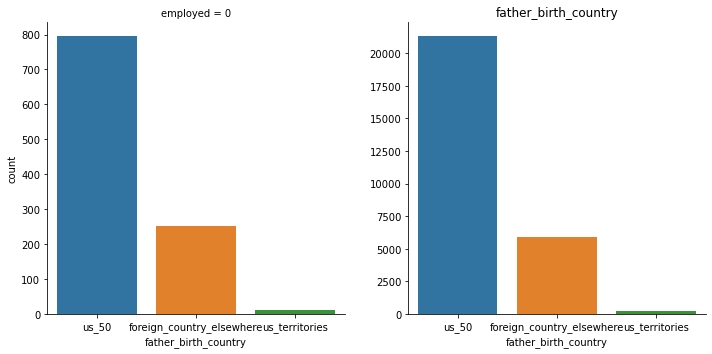

<Figure size 1440x432 with 0 Axes>

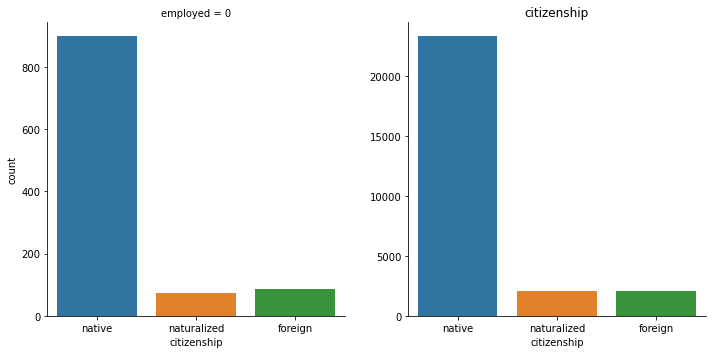

<Figure size 1440x432 with 0 Axes>

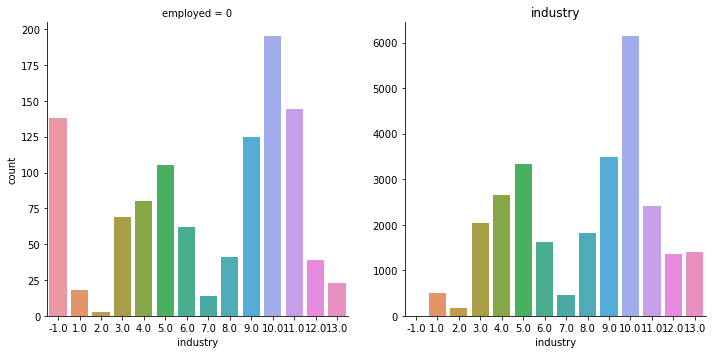

<Figure size 1440x432 with 0 Axes>

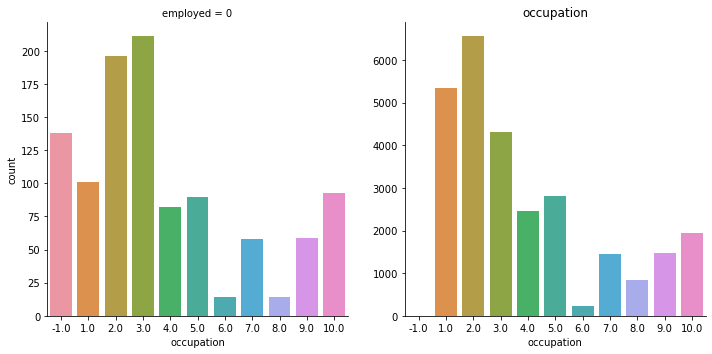

In [14]:
for col in train[categorical_cols]:
    plt.figure(figsize=(20,6))
    sns.catplot(data=train, x=col, col='employed', kind='count', sharey=False)
    #plt.axhline(y=train.employed.mean(), color='red', linestyle='dashed', label='Employement Percentage')
    plt.title(col)
    plt.show()

### Takeaways
* Look for proportionality differences between employed vs not
* Columns for closer inspection
    - `occupation`, `industry`, `marital_status`, `race` 

### Bivariate - Binary Columns

<Figure size 1440x432 with 0 Axes>

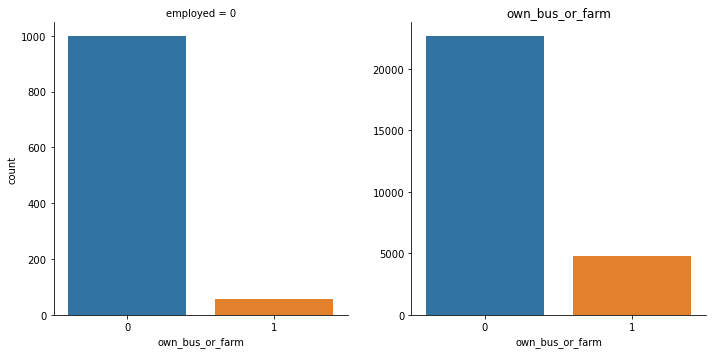

<Figure size 1440x432 with 0 Axes>

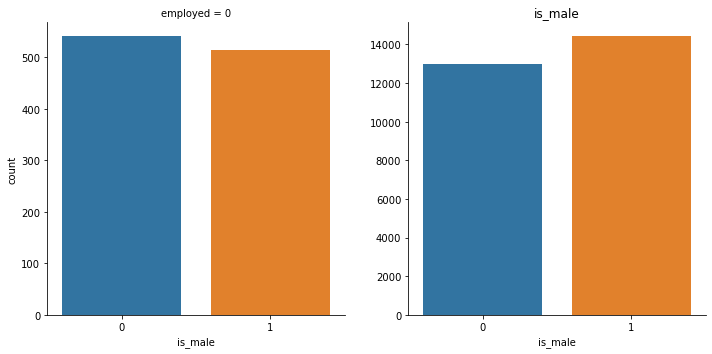

<Figure size 1440x432 with 0 Axes>

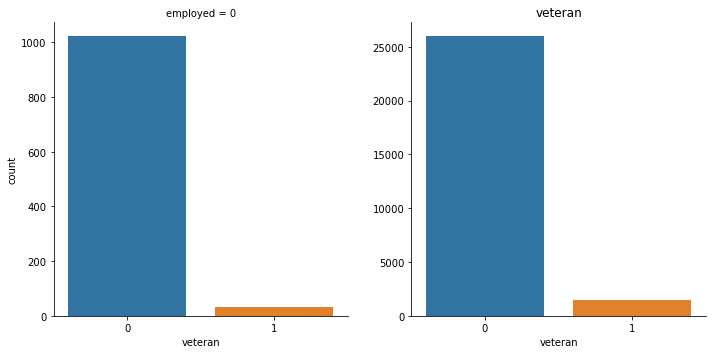

<Figure size 1440x432 with 0 Axes>

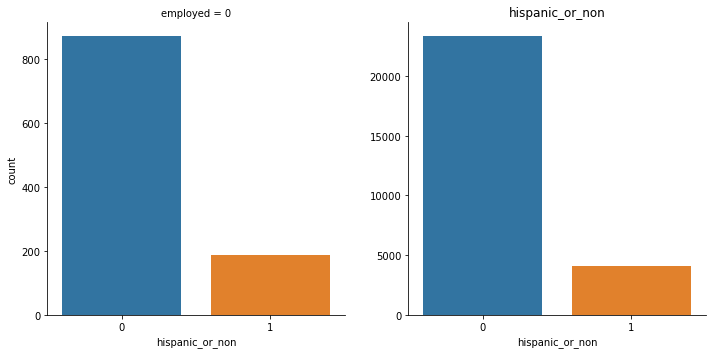

<Figure size 1440x432 with 0 Axes>

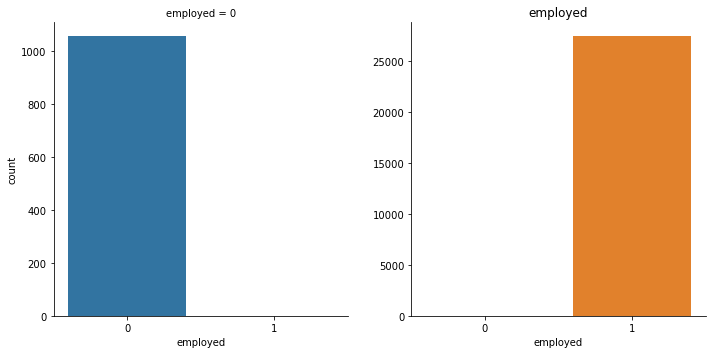

<Figure size 1440x432 with 0 Axes>

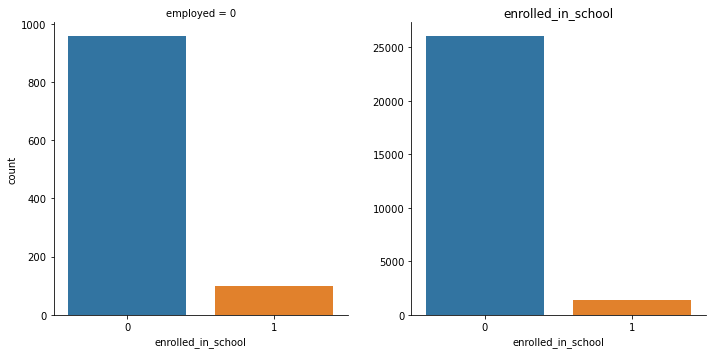

<Figure size 1440x432 with 0 Axes>

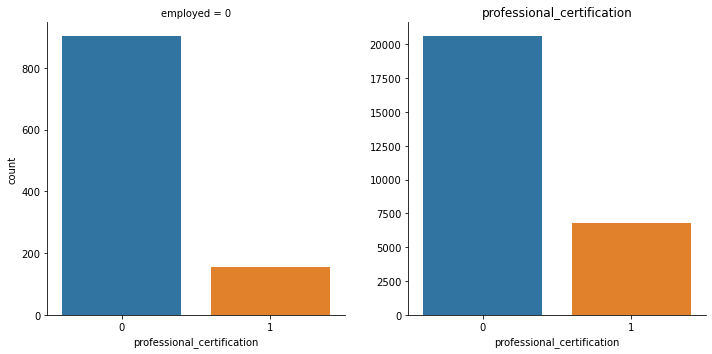

In [15]:
for col in train[binary_cols]:
    plt.figure(figsize=(20,6))
    sns.catplot(data=train, x=col, col='employed', kind='count', sharey=False, orient='y')
    #plt.axhline(y=train.employed.mean(), color='red', linestyle='dashed', label='Employement Percentage')
    plt.title(col)
    plt.show()

### Takeaways
* Gender reversal between employed and not,  change `is_male` --> `is_male` 
* Columns for closer inspection 
    - `professional_certification`
* Remove columns: `could_have_started_job`, `sought_work_last_12_months`, `worked_last_12_months`, `intend_to_look_next_12_months`, `usual_ot_tips_commis`, `disability_preventing_work_in_next_6_months`
    - all columns not represented at all among employed indivduals. leakage likely

## Specific Questions with plots and tests
* Goal:
    Create function for display of unemployment rate and population proportions of column values
* Flow:
    - Chi-2 --> t-test --> feature inclusion
* can bin interesting vs not intersting during feature selection for features the have categories that deviate 

In [33]:
# exported to model.py
def spotlight_stats(df, feature, phase=None):

    multi_col = pd.MultiIndex.from_tuples([('population_proportions', 'employed'), 
                                    ('population_proportions', 'unemployed'),
                                    ('population_proportions', 'change')])
    
    # dataframe, 3 columns, 
    prop_df = pd.DataFrame(columns=multi_col)
    prop_df['unemployment_rate'] = round(1 - train.groupby(by=feature).employed.mean().sort_values(ascending=True), 2)

    # i want to show the proportion of the population that each industry is
    employed_pop_proportion = train[train.employed == 1][feature].value_counts(normalize=True) 

    # i want to show the proportion of the population that each industry is
    unemployed_pop_proportion = train[train.employed == 0][feature].value_counts(normalize=True) 
    
    prop_df[('population_proportions', 'employed')] = employed_pop_proportion
    prop_df[('population_proportions', 'unemployed')] = unemployed_pop_proportion
    prop_df[('population_proportions', 'change')] = employed_pop_proportion - unemployed_pop_proportion

    #chi2
    alpha = .05
    crosstab = pd.crosstab(df[feature], df["employed"])

    chi2, p, dof, expected = chi2_contingency(crosstab)

    if phase == 'explore':
        print('Crosstab\n')
        print(crosstab.values)
        print('---\nExpected\n')
        print(f'{expected.astype(int)}')
        print('---\n')

    print(f'chi^2: {chi2:.4f}')
    print(f'p: {p:.4f}')
    print(f'degrees of freedom: {dof}')

    if p < alpha :
        print('Reject null hypothesis')
    else: 
        print('Fail to reject null hypothesis')

    plt.figure(figsize=(20,6))
    sns.catplot(data=df, x=feature, col='employed', kind='count', sharey=False)
    #plt.axhline(y=train.employed.mean(), color='red', linestyle='dashed', label='Employement Percentage')
    plt.title(feature)
    plt.show()

    return round(prop_df, 3)

### Spotlight - Industry 
* **Question:** Which industry shows the largest population proportion change between employed and unemployed?  
* **Answer:** Leisure and Hospitality. This industry also has the highest unemployment rate at 6%

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between industry of typical employment and employment status   
>* ${H_a}$: There is a relationship between industry of typical employment and employment status  
>* ${\alpha}$: .05  
>* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 3659.8474
p: 0.0000
degrees of freedom: 13
Reject null hypothesis


<Figure size 1440x432 with 0 Axes>

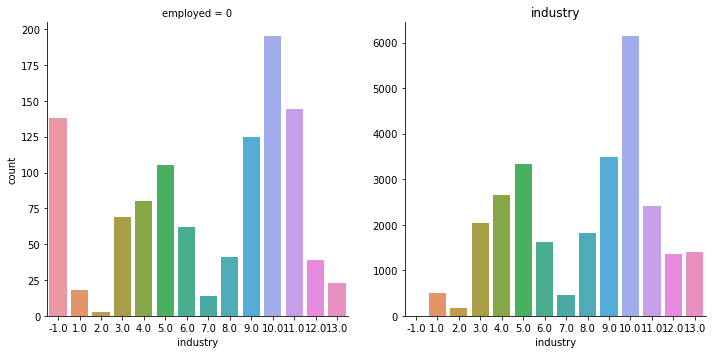

population_proportions                   unemployment_rate
                       employed unemployed change                  
industry                                                           
-1.0                        NaN      0.131    NaN              1.00
 11.0                     0.088      0.136 -0.048              0.06
 6.0                      0.059      0.059  0.000              0.04
 9.0                      0.127      0.118  0.009              0.03
 1.0                      0.019      0.017  0.002              0.03
 3.0                      0.074      0.065  0.009              0.03
 10.0                     0.224      0.185  0.039              0.03
 5.0                      0.122      0.099  0.022              0.03
 7.0                      0.017      0.013  0.004              0.03
 4.0                      0.097      0.076  0.021              0.03
 12.0                     0.050      0.037  0.013              0.03
 8.0                      0.066      0.039  0.027              0.02
 2.0                      0.006      0.003  0.003              0.02
 13.0                     0.051      0.022  0.030              0.02

In [34]:
spotlight_stats(train, 'industry')

#### Statistical Testing

In [ ]:
#chi2

alpha = .05

crosstab = pd.crosstab(df['industry'], df["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[  250     0]
 [   34   867]
 [    9   281]
 [  126  3638]
 [  142  4620]
 [  206  6044]
 [  107  2869]
 [   22   830]
 [   66  3259]
 [  207  6277]
 [  351 10889]
 [  251  4275]
 [   75  2499]
 [   35  2573]
 [    4     0]]
---
Expected

[[    9   240]
 [   33   867]
 [   10   279]
 [  139  3624]
 [  176  4585]
 [  231  6018]
 [  110  2865]
 [   31   820]
 [  123  3201]
 [  240  6243]
 [  417 10822]
 [  167  4358]
 [   95  2478]
 [   96  2511]
 [    0     3]]
---

chi^2: 6738.5352
p: 0.0000
degrees of freedom: 14
Reject null hypothesis


#### Takeaways
>* `Leisure and hospitality` with highest unemployment rate, highest jump in proportionality
>* `Transportaion and utilities` with 2nd highest

### Spotlight - Occupation
>* **Question:** Which occupation shows the largest population proportion change between employed and unemployed?  
>* **Answer:** Farming, Fishing, and Forestry occupations. These occupations also have the highest unemployment rate at 6%

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between occupation and employment status  
>* ${H_a}$: There is a relationship between occupation and employment status  
>* ${\alpha}$: .05
>* Result: Reject the null hyptothesis. **Test Code Below**

In [ ]:
spotlight_stats(train, 'occupation')

population_proportions                   unemployment_rate
                         employed unemployed change                  
occupation                                                           
-1.0                          NaN      0.131    NaN              1.00
 6.0                        0.008      0.013 -0.005              0.06
 3.0                        0.157      0.200 -0.043              0.05
 10.0                       0.071      0.088 -0.017              0.05
 9.0                        0.054      0.056 -0.002              0.04
 7.0                        0.053      0.055 -0.002              0.04
 4.0                        0.090      0.078  0.012              0.03
 5.0                        0.103      0.085  0.017              0.03
 2.0                        0.239      0.186  0.054              0.03
 1.0                        0.195      0.096  0.100              0.02
 8.0                        0.030      0.013  0.017              0.02

#### Statistical Testing

In [ ]:
#chi2

alpha = .05

crosstab = pd.crosstab(df['occupation'], df["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[  250     0]
 [  154  9383]
 [  338 11900]
 [  375  7682]
 [  156  4423]
 [  159  4988]
 [   26   373]
 [  117  2549]
 [   25  1538]
 [  102  2564]
 [  179  3521]
 [    4     0]]
---
Expected

[[    9   240]
 [  353  9183]
 [  454 11783]
 [  298  7758]
 [  169  4409]
 [  190  4956]
 [   14   384]
 [   98  2567]
 [   57  1505]
 [   98  2567]
 [  137  3562]
 [    0     3]]
---

chi^2: 6811.8559
p: 0.0000
degrees of freedom: 11
Reject null hypothesis


### Takeways
* Farming fishing and forestry at the top
* service occupations, transportation and material movie tied for 2nd
* service occupations highest change in proportionality

### Spotlight - Marital Status
* **Question:** Which marital status disposition shows the largest population proportion change between employed and unemployed?  
* **Answer:** Single individuals make up a larger share of the unemployed and have an unemployment rate of 5%.

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between `marital_status` and `employment` status   
>* ${H_a}$: There is a relationship between `marital_status` and `employment` status  
>* ${\alpha}$: .05  
>* Result: There is enough evidence to reject our null hypothesis. **Test code below**

In [ ]:
spotlight_stats(train, 'marital_status')

population_proportions                   unemployment_rate
                             employed unemployed change                  
marital_status                                                           
single                          0.441      0.656 -0.215              0.05
married                         0.559      0.344  0.215              0.02

#### Statistical Testing

In [ ]:
#chi2

alpha = .05

crosstab = pd.crosstab(df['marital_status'], df["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[  624 27416]
 [ 1261 21505]]
---
Expected

[[ 1040 26999]
 [  844 21921]]
---

chi^2: 385.2312
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


#### Takeaways
* `single` individuals with highest unemployment rate, highest jump in proportionality

### Spotlight - Race
* **Question:** Which industry shows the largest population proportion change between employed and unemployed?  
* **Answer:** Indivduals identifying as White show the largest population proportion change with a drop of nearly 10% when comparing employed vs unemployed. Those identifying as mixed race other than with white, and Indigenous have the highest unemployed rates at 12% and 7% respectively. 

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between `race` and `employment` status   
>* ${H_a}$: There is a relationship between `race` and `employment` status   
>* ${\alpha}$: .05  
>* Result: There is enough evidence to reject our null hypothesis. **Test code below**

In [ ]:
spotlight_stats(train, 'race')

population_proportions                   unemployment_rate
                          employed unemployed change                  
race                                                                  
mixed_other                  0.003      0.012 -0.009              0.12
AI/NA                        0.012      0.023 -0.011              0.07
black                        0.099      0.175 -0.076              0.06
HI/PI                        0.006      0.009 -0.003              0.06
mixed_white                  0.016      0.024 -0.008              0.06
white                        0.801      0.705  0.095              0.03
asian                        0.063      0.052  0.011              0.03

#### Statistical Testing

In [ ]:
#chi2

alpha = .05

crosstab = pd.crosstab(df['race'], df["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[   39   552]
 [   12   262]
 [   94  3162]
 [  333  4781]
 [   19   157]
 [   44   739]
 [ 1344 39268]]
---
Expected

[[   21   569]
 [   10   263]
 [  120  3135]
 [  189  4924]
 [    6   169]
 [   29   753]
 [ 1506 39105]]
---

chi^2: 183.6449
p: 0.0000
degrees of freedom: 6
Reject null hypothesis


#### Takeways
* Mixed raced top of unemployed
* indeginous, black, and hi/pi among tops in unemployment
* black with highest change in proportionality 

### Spotlight - Professional Certification
* **Question:** What is the effect of having a professional certification?  
* **Answer:** Leisure and Hospitality. This industry also has the highest unemployment rate at 6%

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between having a `professional_certification` and `employment`  
>* ${H_a}$: There is a relationship between having a `professional_certification` and `employment`    
>* ${\alpha}$: .05
>* Result: There is enough evidence to reject our null hypothesis. **Test code below**

In [ ]:
spotlight_stats(train, 'professional_certification')

population_proportions                    \
                                         employed unemployed change   
professional_certification                                            
0                                           0.752      0.854 -0.102   
1                                           0.248      0.146  0.102   

                           unemployment_rate  
                                              
professional_certification                    
0                                       0.04  
1                                       0.02

#### Statistical Testing

In [145]:
#chi2

alpha = .05

crosstab = pd.crosstab(df['professional_certification'], df["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[ 1619 36658]
 [  266 12263]]
---
Expected

[[ 1420 36856]
 [  464 12064]]
---

chi^2: 116.6670
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


#### Takeways
* Double the unemployment rate for those without a professional_certification
* service occupations, transportation and material movoie tied for 2nd

In [39]:
reload(model)

<module 'model' from '/Users/sinao/codeup-data-science/unemployment_project/model.py'>

chi^2: 56.8554
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


<Figure size 1440x432 with 0 Axes>

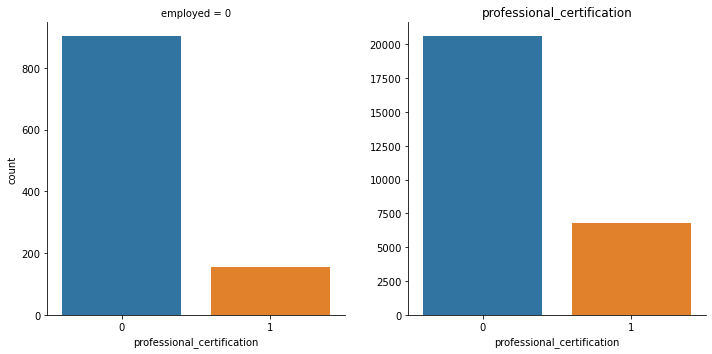

population_proportions                    \
                                         employed unemployed change   
professional_certification                                            
0                                           0.752      0.854 -0.102   
1                                           0.248      0.146  0.102   

                           unemployment_rate  
                                              
professional_certification                    
0                                       0.04  
1                                       0.02

In [40]:
model.spotlight_stats(train, 'professional_certification')